## Reproducing the Educational Example (see Appendix A) of the paper PhysRevX.12.011059 by Sivak et al.

We want to implement a Reinforcement Learning (RL) model (which is a classical Neural Network) and train its agent to learn the rotation angle $\theta$ to flip the incoming quantum state $\ket{0}$ to the $\ket{1}$ state by applying a RX-gate($\theta$).

This code is implemented in ``PyTorch`` and bases its architecture on the one by Mr. Arthur Strauss who used ``TensorFlow`` (https://github.com/arthurostrauss/Quantum_Optimal_Control/tree/main/paper_results)

#### Imports

In [548]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm
from scipy.linalg import sqrtm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.optim as optim

from qiskit import QuantumCircuit
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi

#### The RL agent performs an action

To measure in the Hadamard basis (or X-basis), you can use the Hadamard gate. Specifically, before performing the measurement on a qubit prepared in a certain state, apply a Hadamard gate. This gate transforms the state from the computational (Z) basis to the Hadamard (X) basis. After applying the Hadamard gate, you can measure in the usual Z-basis, which effectively corresponds to a measurement in the X-basis.

**To measure the $\ket{+}$ state in the Hadamard basis:**

- Apply a Hadamard gate on the qubit that's in the $\ket{+}$ state.
- Measure in the computational basis ($\ket{0}$ and $\braket{0}$).
- The outcome of the measurement is then in the Hadamard basis.

**To measure the $\ket{-}$ state in the Hadamard basis:**

- Apply a z-gate on the qubit
- Apply a Hadamard gate on the qubit that's in the $\ket{-}$ state.
- Measure in the computational basis ($\ket{0}$ and $\braket{0}$).
- The outcome of the measurement is then in the Hadamard basis.

Estimate a density matrix based on the binary (either 0 or 1) measurement outcomes of the quantum circuit

In [549]:
target_states = {
    '1': np.array([0, 1]),
    '+': (1/np.sqrt(2)) * np.array([+1, +1]),
    '-': (1/np.sqrt(2)) * np.array([+1, -1]),
}

In [550]:
def get_dm(state: np.ndarray) -> np.ndarray:
    return np.outer(state, np.conj(state))

def get_fidelity(rho, sigma):
    """
    Compute the fidelity between two quantum states represented by density matrices.
    
    Parameters:
    - rho (numpy.ndarray): Density matrix of the first quantum state.
    - sigma (numpy.ndarray): Density matrix of the second quantum state.
    
    Returns:
    - float: Fidelity between the two quantum states.
    
    Note:
    This function assumes that the input density matrices are valid (positive, trace 1) and of the same size.
    """
    
    # Computing the square root of rho
    sqrt_rho = sqrtm(rho)
    
    # Calculating the product sqrt_rho * sigma * sqrt_rho
    temp_product = np.dot(np.dot(sqrt_rho, sigma), sqrt_rho)
    
    # Taking the square root of the product
    root_product = sqrtm(temp_product)
    
    # Calculating the trace
    fidelity = np.real(np.trace(root_product))
    
    return fidelity

# Testing with example pure states, here orthogonal states (F = 0)
psi = np.array([1, 0])
phi = np.array([1, 0])

psi_dm = get_dm(state=psi)
phi_dm = get_dm(state=phi)

print(f'Fidelity F = {round(get_fidelity(psi_dm, phi_dm), 6)}')  # This should be close to 0 for orthogonal states

Fidelity F = 1.0


In [551]:
def estimate_dm(counts: dict, shots: int, batch: int) -> np.ndarray:
    # Construct the estimated density matrix

    p0 = counts.get('0', 0) / (shots * batch)
    p1 = counts.get('1', 0) / (shots * batch)

    return np.array([[p0, 0], [0, p1]])

In [552]:
target_state_str = '+'
target_state = target_states[target_state_str]
print('Target state:', target_state)

Target state: [0.70710678 0.70710678]


In [553]:
def perform_action(amp, shots=1, target_state_str=target_state_str):
    """
    Execute a quantum circuit with parametrized amplitude, retrieve measurement result and assign rewards accordingly
        
        :param amp: amplitude parameter, provided as an array of size batchsize
        :param shots: number of evaluations to be done on the quantum computer
        :param target: string indicating the target state ('1' or '+')
    
        :return: Reward table (reward for each run in the batch)
    """
    global qc, qasm, target_states
    angles, batch = np.array(amp), len(np.array(amp))
    reward_table = np.zeros(batch)

    estimated_dm = np.zeros([2,2], dtype='complex128')

    for ind, angle in enumerate(angles):
        if target_state_str == '1':
            qc.rx(2 * np.pi * angle, 0)  # Add parametrized gate for each amplitude in the batch
            q_state = qi.Statevector.from_instruction(qc)
            estimated_dm += np.array(q_state.to_operator()) / batch
            
        elif target_state_str == '+':
            qc.ry(2 * np.pi * angle, 0)  # Add parametrized gate for each amplitude in the batch  
            q_state = qi.Statevector.from_instruction(qc)
            estimated_dm += np.array(q_state.to_operator()) / batch  
            qc.h(0) # Transform to hadamard basis before measurement
            
        elif target_state_str == '-':
            qc.ry(2 * np.pi * angle, 0)
            q_state = qi.Statevector.from_instruction(qc)
            estimated_dm += np.array(q_state.to_operator()) / batch
            qc.z(0)  # Apply Z gate for the minus state
            qc.h(0) # Transform to hadamard basis before measurement
        
        qc.measure(0, 0)  # Measurement
        job = qasm.run(qc, shots=shots)
        result = job.result()
        counts = result.get_counts(qc)  # Returns a dict with keys '0' and '1' (possible measurement outcomes) with number of counts for each key

        # Estimate the density matrix of the output state based on the binary measurement outcomes
        # estimated_dm = estimate_dm(counts=counts, shots=shots, batch=batch)
        """p0 = counts.get('0', 0)
        p1 = counts.get('1', 0)
        estimated_dm += np.array([[p0, 0], [0, p1]]) / (shots * batch)"""
        
        # Calculate reward
        if target_state_str == '1':
            reward_table[ind] += np.mean(np.array([1] * counts.get('1', 0) + [-1] * counts.get('0', 0)))
        elif target_state_str in ['+', '-']:
            reward_table[ind] += np.mean(np.array([1] * counts.get('0', 0) + [-1] * counts.get('1', 0)))
        else:
            if ind % 10 == 0:
                print('!! Reward calculation FAILS !!')

        qc.clear()

    return reward_table, estimated_dm

#### Set Hyperparameters for the RL

In [554]:
# Variables to define environment
qc = QuantumCircuit(1, 1)  # Two-level system of interest, 1 qubit
qasm = QasmSimulator(method="statevector")  # Simulation backend (mock quantum computer)

seed = 2364

# Hyperparameters for the agent
n_epochs = 200
batch_size = 50
eta = 0.01  # Learning rate for policy update step

# Policy parameters
mu = nn.Parameter(torch.randn([]) * 0.05)  # Initializing mu with a value drawn from a normal distribution with mean 0, sigma 0.05
sigma = nn.Parameter(torch.tensor(0.05))  # Initializing sigma with a value of 0.05

# Critic parameter (single state-independent baseline b)
b = nn.Parameter(torch.tensor(0.))

#### Training

In [555]:
# Create an optimizer for the trainable parameters
optimizer = optim.Adam([mu, sigma, b], lr=eta)
epsilon = 1e-3 # Small offset to avoid sigma = 0
 # Clip the gradients
grad_clip = 0.3

def constrain_mu(value, min_val, max_val):
    return torch.clamp(value, min_val, max_val)

def constrain_sigma(value):
    return torch.relu(value) # Ensures that sigma is non-negative

# Dictionary to keep track of the used parameters
params = {
            'mu': [],
            'sigma': [],
            'reward': [],
            'fidelity': [],
            'learning_rate': eta,
            'seed': seed,
            'batch_size': batch_size,
            'n_epochs': n_epochs,
}

### Training loop
for epoch in tqdm(range(n_epochs)):
    print('\nEPOCH', epoch+1)
    print('Policy parameter')
    print(f'mu = {mu.item()} +- sigma = {sigma.item()}')
    print('baseline', b.item())

    # Sample action from policy (Gaussian distribution with parameters mu and sigma)
    Normal_distrib = Normal(loc=mu, scale=sigma + epsilon)
    action = Normal_distrib.sample((batch_size,)) # action 

    # Run quantum circuit to retrieve rewards (in this example, only one time step)
    reward, estimated_dm = perform_action(action, shots=1, target_state_str=target_state_str)
    target_state_dm = get_dm(target_states[target_state_str])
    fidelity = qi.state_fidelity(target_state_dm, estimated_dm)     #get_fidelity(target_state_dm, estimated_dm)
    
    print("Average Return:", reward.mean().item())
    print('Target state: ', target_state)
    print('Fidelity: ', fidelity)

    advantage = torch.tensor(reward, dtype=torch.float32) - b
    
    log_probs = Normal_distrib.log_prob(action)

    actor_loss = -(advantage * log_probs).mean()
    critic_loss = (advantage ** 2).mean()
    critic_loss_coeff = 0.5
    combined_loss = actor_loss + critic_loss_coeff * critic_loss

    # Clear previous gradients
    optimizer.zero_grad() 
    # Backpropagation
    combined_loss.backward()
    # Clip the gradients
    torch.nn.utils.clip_grad_norm_([mu, sigma, b], grad_clip)
    # Apply gradients
    optimizer.step()

    # During training, after each optimizer step:
    with torch.no_grad():
        mu.data = constrain_mu(mu.data, -2., 2.)
        sigma.data = constrain_sigma(sigma.data)
  
    params["mu"].append(mu.item())
    params["sigma"].append(sigma.item())
    params["reward"].append(reward)
    params["fidelity"].append(fidelity)

  2%|▏         | 4/200 [00:00<00:05, 37.24it/s]


EPOCH 1
Policy parameter
mu = 0.04748203232884407 +- sigma = 0.05000000074505806
baseline 0.0
Average Return: 0.36
Target state:  [0.70710678 0.70710678]
Fidelity:  0.636541180351286

EPOCH 2
Policy parameter
mu = 0.0574820302426815 +- sigma = 0.04000000283122063
baseline -0.009999996051192284
Average Return: 0.36
Target state:  [0.70710678 0.70710678]
Fidelity:  0.6748732863134076

EPOCH 3
Policy parameter
mu = 0.06746360659599304 +- sigma = 0.03347744420170784
baseline -0.019936788827180862
Average Return: 0.36
Target state:  [0.70710678 0.70710678]
Fidelity:  0.6955498261442747

EPOCH 4
Policy parameter
mu = 0.0773724764585495 +- sigma = 0.03391331806778908
baseline -0.029440585523843765
Average Return: 0.28
Target state:  [0.70710678 0.70710678]
Fidelity:  0.6862060378852431

EPOCH 5
Policy parameter
mu = 0.08602112531661987 +- sigma = 0.029782423749566078
baseline -0.0387558750808239
Average Return: 0.44
Target state:  [0.70710678 0.70710678]
Fidelity:  0.7655216226830526

EPOCH 

  8%|▊         | 15/200 [00:00<00:03, 47.43it/s]

Average Return: 0.76
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8253218962074245

EPOCH 10
Policy parameter
mu = 0.11601722240447998 +- sigma = 0.003978908993303776
baseline -0.08356679230928421
Average Return: 0.72
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8298182798616837

EPOCH 11
Policy parameter
mu = 0.11594686657190323 +- sigma = 0.0013546391855925322
baseline -0.09188869595527649
Average Return: 0.56
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8317509830882452

EPOCH 12
Policy parameter
mu = 0.11609243601560593 +- sigma = 0.0
baseline -0.09962726384401321
Average Return: 0.52
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8333592372495011

EPOCH 13
Policy parameter
mu = 0.11564648151397705 +- sigma = 0.0
baseline -0.10692226141691208
Average Return: 0.44
Target state:  [0.70710678 0.70710678]
Fidelity:  0.832636080427858

EPOCH 14
Policy parameter
mu = 0.11448976397514343 +- sigma = 0.0
baseline -0.11369691044092178
Average Return: 0.68
Target sta

 12%|█▎        | 25/200 [00:00<00:03, 47.75it/s]


EPOCH 20
Policy parameter
mu = 0.11136023700237274 +- sigma = 0.0
baseline -0.145318865776062
Average Return: 0.68
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8221532598104245

EPOCH 21
Policy parameter
mu = 0.11301039159297943 +- sigma = 0.0
baseline -0.14948448538780212
Average Return: 0.48
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8260669609915394

EPOCH 22
Policy parameter
mu = 0.11579756438732147 +- sigma = 0.0
baseline -0.15336832404136658
Average Return: 0.52
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8323030633577836

EPOCH 23
Policy parameter
mu = 0.11651084572076797 +- sigma = 0.0
baseline -0.15700697898864746
Average Return: 0.76
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8344106459429987

EPOCH 24
Policy parameter
mu = 0.11755502969026566 +- sigma = 0.0
baseline -0.16067463159561157
Average Return: 0.52
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8368448823189941

EPOCH 25
Policy parameter
mu = 0.11790327727794647 +- sigma = 0.0


 18%|█▊        | 37/200 [00:00<00:03, 50.49it/s]

Average Return: 0.72
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8121766104074116

EPOCH 30
Policy parameter
mu = 0.10384780168533325 +- sigma = 0.0
baseline -0.17885731160640717
Average Return: 0.76
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8037997190820818

EPOCH 31
Policy parameter
mu = 0.10110337287187576 +- sigma = 0.0
baseline -0.18146410584449768
Average Return: 0.56
Target state:  [0.70710678 0.70710678]
Fidelity:  0.7967416221710074

EPOCH 32
Policy parameter
mu = 0.09908448159694672 +- sigma = 0.0
baseline -0.18407219648361206
Average Return: 0.68
Target state:  [0.70710678 0.70710678]
Fidelity:  0.7915370004029697

EPOCH 33
Policy parameter
mu = 0.09782691299915314 +- sigma = 0.0
baseline -0.18662595748901367
Average Return: 0.6
Target state:  [0.70710678 0.70710678]
Fidelity:  0.7884084868019876

EPOCH 34
Policy parameter
mu = 0.09745503962039948 +- sigma = 0.0
baseline -0.18922972679138184
Average Return: 0.48
Target state:  [0.70710678 0.70710678]
Fideli

 24%|██▍       | 49/200 [00:00<00:02, 52.02it/s]

Average Return: 0.68
Target state:  [0.70710678 0.70710678]
Fidelity:  0.7824092230850538

EPOCH 41
Policy parameter
mu = 0.09651187807321548 +- sigma = 0.0
baseline -0.20930920541286469
Average Return: 0.52
Target state:  [0.70710678 0.70710678]
Fidelity:  0.7846650705428292

EPOCH 42
Policy parameter
mu = 0.09822198748588562 +- sigma = 0.0
baseline -0.21217992901802063
Average Return: 0.44
Target state:  [0.70710678 0.70710678]
Fidelity:  0.7892226196488108

EPOCH 43
Policy parameter
mu = 0.10017362236976624 +- sigma = 0.0
baseline -0.2149830013513565
Average Return: 0.52
Target state:  [0.70710678 0.70710678]
Fidelity:  0.7948608867457737

EPOCH 44
Policy parameter
mu = 0.10286011546850204 +- sigma = 0.0
baseline -0.2177393138408661
Average Return: 0.64
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8014450784026972

EPOCH 45
Policy parameter
mu = 0.10475868731737137 +- sigma = 0.0
baseline -0.22035348415374756
Average Return: 0.8
Target state:  [0.70710678 0.70710678]
Fidelity

 28%|██▊       | 55/200 [00:01<00:02, 52.18it/s]

Average Return: 0.68
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8489555032183133

EPOCH 52
Policy parameter
mu = 0.12710736691951752 +- sigma = 0.0
baseline -0.24228425323963165
Average Return: 0.76
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8581034970618202

EPOCH 53
Policy parameter
mu = 0.13053207099437714 +- sigma = 0.0
baseline -0.2453019917011261
Average Return: 0.72
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8654628217325057

EPOCH 54
Policy parameter
mu = 0.1331777274608612 +- sigma = 0.0
baseline -0.24832923710346222
Average Return: 0.64
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8713762601419807

EPOCH 55
Policy parameter
mu = 0.13604196906089783 +- sigma = 0.0
baseline -0.2513902187347412
Average Return: 0.8
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8774291750876162

EPOCH 56
Policy parameter
mu = 0.13995124399662018 +- sigma = 0.0
baseline -0.2542855441570282
Average Return: 0.68
Target state:  [0.70710678 0.70710678]
Fidelity: 

 33%|███▎      | 66/200 [00:01<00:02, 46.95it/s]

Average Return: 0.84
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9084142583533606

EPOCH 62
Policy parameter
mu = 0.15448202192783356 +- sigma = 0.0
baseline -0.27191078662872314
Average Return: 0.84
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9125439342251747

EPOCH 63
Policy parameter
mu = 0.1555347591638565 +- sigma = 0.0
baseline -0.2748728394508362
Average Return: 0.8
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9141248590378965

EPOCH 64
Policy parameter
mu = 0.1547316312789917 +- sigma = 0.0
baseline -0.27802881598472595
Average Return: 0.88
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9134400365024533

EPOCH 65
Policy parameter
mu = 0.15504401922225952 +- sigma = 0.0
baseline -0.28107041120529175
Average Return: 0.84
Target state:  [0.70710678 0.70710678]
Fidelity:  0.913767640603845

EPOCH 66
Policy parameter
mu = 0.15446767210960388 +- sigma = 0.0
baseline -0.28477299213409424
Average Return: 0.84
Target state:  [0.70710678 0.70710678]
Fidelity: 

 38%|███▊      | 77/200 [00:01<00:02, 48.33it/s]

Average Return: 0.68
Target state:  [0.70710678 0.70710678]
Fidelity:  0.907789335793444

EPOCH 71
Policy parameter
mu = 0.15226300060749054 +- sigma = 0.0
baseline -0.3017434775829315
Average Return: 0.84
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9087478487049266

EPOCH 72
Policy parameter
mu = 0.15312063694000244 +- sigma = 0.0
baseline -0.304735392332077
Average Return: 0.8
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9100503891338451

EPOCH 73
Policy parameter
mu = 0.1522018015384674 +- sigma = 0.0
baseline -0.3082885444164276
Average Return: 0.84
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9079012920695181

EPOCH 74
Policy parameter
mu = 0.14984764158725739 +- sigma = 0.0
baseline -0.31159400939941406
Average Return: 0.8
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9043868513661251

EPOCH 75
Policy parameter
mu = 0.14721786975860596 +- sigma = 0.0
baseline -0.31537196040153503
Average Return: 0.6
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8

 44%|████▍     | 89/200 [00:01<00:02, 50.57it/s]

Average Return: 0.8
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8853176247910451

EPOCH 82
Policy parameter
mu = 0.14012280106544495 +- sigma = 0.0
baseline -0.340821236371994
Average Return: 0.84
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8852307489670632

EPOCH 83
Policy parameter
mu = 0.1394105851650238 +- sigma = 0.0
baseline -0.34422338008880615
Average Return: 0.76
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8837964439740287

EPOCH 84
Policy parameter
mu = 0.1379125565290451 +- sigma = 0.0
baseline -0.3474894165992737
Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.881073282641661

EPOCH 85
Policy parameter
mu = 0.13674241304397583 +- sigma = 0.0
baseline -0.3506017029285431
Average Return: 0.84
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8788614353525764

EPOCH 86
Policy parameter
mu = 0.13660696148872375 +- sigma = 0.0002088317123707384
baseline -0.35410359501838684
Average Return: 0.8
Target state:  [0.70710678 0.707106

 50%|█████     | 101/200 [00:02<00:01, 51.69it/s]

Average Return: 0.8
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8966106601026419

EPOCH 93
Policy parameter
mu = 0.1452518105506897 +- sigma = 0.0
baseline -0.3772812485694885
Average Return: 0.8
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8955000036010922

EPOCH 94
Policy parameter
mu = 0.14323608577251434 +- sigma = 0.0
baseline -0.38026392459869385
Average Return: 0.8
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8918446211448561

EPOCH 95
Policy parameter
mu = 0.14305400848388672 +- sigma = 0.0
baseline -0.38316893577575684
Average Return: 0.88
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8918317247076929

EPOCH 96
Policy parameter
mu = 0.1445690244436264 +- sigma = 0.0
baseline -0.3859398663043976
Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.89447569148967

EPOCH 97
Policy parameter
mu = 0.1471053510904312 +- sigma = 0.0
baseline -0.38869306445121765
Average Return: 0.8
Target state:  [0.70710678 0.70710678]
Fidelity:  0.899

 56%|█████▋    | 113/200 [00:02<00:01, 52.52it/s]

Average Return: 0.92
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9410169759964624

EPOCH 104
Policy parameter
mu = 0.17619448900222778 +- sigma = 0.0
baseline -0.40841326117515564
Average Return: 0.84
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9469416470019381

EPOCH 105
Policy parameter
mu = 0.17856061458587646 +- sigma = 0.0
baseline -0.411744087934494
Average Return: 0.84
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9504980605677109

EPOCH 106
Policy parameter
mu = 0.18021567165851593 +- sigma = 0.0
baseline -0.4149155020713806
Average Return: 0.88
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9526980918267285

EPOCH 107
Policy parameter
mu = 0.1818002164363861 +- sigma = 0.0
baseline -0.41794806718826294
Average Return: 0.92
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9546112196294091

EPOCH 108
Policy parameter
mu = 0.18202348053455353 +- sigma = 0.0
baseline -0.4208804666996002
Average Return: 0.88
Target state:  [0.70710678 0.70710678]
Fidel

 60%|█████▉    | 119/200 [00:02<00:01, 52.68it/s]

Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9466007985266792

EPOCH 115
Policy parameter
mu = 0.1750330775976181 +- sigma = 0.0
baseline -0.44739624857902527
Average Return: 0.92
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9456266089584207

EPOCH 116
Policy parameter
mu = 0.1751290261745453 +- sigma = 0.0
baseline -0.4511377811431885
Average Return: 0.8
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9461298677208906

EPOCH 117
Policy parameter
mu = 0.1765632927417755 +- sigma = 0.0
baseline -0.45463046431541443
Average Return: 0.92
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9475353001696217

EPOCH 118
Policy parameter
mu = 0.1767551153898239 +- sigma = 0.0
baseline -0.45806676149368286
Average Return: 0.88
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9479550063976931

EPOCH 119
Policy parameter
mu = 0.17715215682983398 +- sigma = 0.0
baseline -0.4635620415210724
Average Return: 0.88
Target state:  [0.70710678 0.70710678]
Fidelit

 66%|██████▌   | 131/200 [00:02<00:01, 52.93it/s]

Average Return: 0.92
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9542753035347524

EPOCH 126
Policy parameter
mu = 0.18270348012447357 +- sigma = 0.0
baseline -0.49439185857772827
Average Return: 0.84
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9557222746752096

EPOCH 127
Policy parameter
mu = 0.18206660449504852 +- sigma = 0.0
baseline -0.49807071685791016
Average Return: 0.76
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9554785125327289

EPOCH 128
Policy parameter
mu = 0.18310312926769257 +- sigma = 0.0
baseline -0.5016022324562073
Average Return: 0.84
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9566406616349608

EPOCH 129
Policy parameter
mu = 0.18521519005298615 +- sigma = 0.0
baseline -0.5049738883972168
Average Return: 0.88
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9593953941104807

EPOCH 130
Policy parameter
mu = 0.18813712894916534 +- sigma = 0.0009128256933763623
baseline -0.5081469416618347
Average Return: 0.92
Target state:  [0.707106

 72%|███████▏  | 143/200 [00:02<00:01, 53.02it/s]

Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9738416951015071

EPOCH 137
Policy parameter
mu = 0.20180942118167877 +- sigma = 0.0
baseline -0.5364502668380737
Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9772126974457913

EPOCH 138
Policy parameter
mu = 0.204861581325531 +- sigma = 0.0
baseline -0.5406834483146667
Average Return: 0.92
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9800301735350802

EPOCH 139
Policy parameter
mu = 0.208029106259346 +- sigma = 0.0
baseline -0.544640064239502
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.98272863049976

EPOCH 140
Policy parameter
mu = 0.21122437715530396 +- sigma = 0.0
baseline -0.5484422445297241
Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9853835995341034

EPOCH 141
Policy parameter
mu = 0.21567480266094208 +- sigma = 0.0
baseline -0.552058219909668
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.98

 78%|███████▊  | 155/200 [00:03<00:00, 51.55it/s]

Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9945323166779915

EPOCH 148
Policy parameter
mu = 0.2283392697572708 +- sigma = 0.006028768606483936
baseline -0.5747426152229309
Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9944290522049919

EPOCH 149
Policy parameter
mu = 0.2287847101688385 +- sigma = 0.006140430457890034
baseline -0.5784736275672913
Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9949552635168527

EPOCH 150
Policy parameter
mu = 0.23040573298931122 +- sigma = 0.006126569118350744
baseline -0.5881643891334534
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.996032808962351

EPOCH 151
Policy parameter
mu = 0.2324904352426529 +- sigma = 0.007307912688702345
baseline -0.5970859527587891
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9969126041505075

EPOCH 152
Policy parameter
mu = 0.2352668195962906 +- sigma = 0.007302732206881046
baseline -0.60553

 80%|████████  | 161/200 [00:03<00:00, 47.95it/s]

Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9981769486057362

EPOCH 158
Policy parameter
mu = 0.26012277603149414 +- sigma = 0.010433828458189964
baseline -0.6579605340957642
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9977488943438196

EPOCH 159
Policy parameter
mu = 0.2650795578956604 +- sigma = 0.009152453392744064
baseline -0.6657909154891968
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9961181417674847

EPOCH 160
Policy parameter
mu = 0.2703091502189636 +- sigma = 0.009137822315096855
baseline -0.6732114553451538
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9951564063932509

EPOCH 161
Policy parameter
mu = 0.27452000975608826 +- sigma = 0.007902351208031178
baseline -0.6809267401695251
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9928316633516358

EPOCH 162
Policy parameter
mu = 0.27948564291000366 +- sigma = 0.007650719489902258
baseline -0.6886

 86%|████████▌ | 171/200 [00:03<00:00, 45.57it/s]

Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9838607427358963

EPOCH 167
Policy parameter
mu = 0.29182034730911255 +- sigma = 0.0007553637260571122
baseline -0.7244019508361816
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9828590960639764

EPOCH 168
Policy parameter
mu = 0.29300227761268616 +- sigma = 0.0014862753450870514
baseline -0.7306206226348877
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9816472772016887

EPOCH 169
Policy parameter
mu = 0.2952475845813751 +- sigma = 0.0012790707405656576
baseline -0.736693263053894
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9799995419961182

EPOCH 170
Policy parameter
mu = 0.2970183491706848 +- sigma = 0.0023644943721592426
baseline -0.7422689199447632
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9777876389109011

EPOCH 171
Policy parameter
mu = 0.2992815375328064 +- sigma = 0.004510411061346531
baseline -0.74

 90%|█████████ | 181/200 [00:03<00:00, 45.40it/s]

Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9686447028807045

EPOCH 176
Policy parameter
mu = 0.30778074264526367 +- sigma = 0.004946974106132984
baseline -0.7723041772842407
Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9665280807396808

EPOCH 177
Policy parameter
mu = 0.30883464217185974 +- sigma = 0.005413821432739496
baseline -0.7773517370223999
Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9663518639451659

EPOCH 178
Policy parameter
mu = 0.3093756437301636 +- sigma = 0.004593667574226856
baseline -0.7823710441589355
Average Return: 0.92
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9655182832256799

EPOCH 179
Policy parameter
mu = 0.3097376823425293 +- sigma = 0.0025811016093939543
baseline -0.7872604131698608
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9649808875761939

EPOCH 180
Policy parameter
mu = 0.3103291392326355 +- sigma = 0.0020329169929027557
baseline -0

 96%|█████████▌| 191/200 [00:03<00:00, 45.10it/s]

Average Return: 0.92
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9663269353905558

EPOCH 186
Policy parameter
mu = 0.30712756514549255 +- sigma = 0.0013568878639489412
baseline -0.8215717673301697
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9681950021541378

EPOCH 187
Policy parameter
mu = 0.3055766224861145 +- sigma = 0.0022708000615239143
baseline -0.8257012963294983
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.969950061025588

EPOCH 188
Policy parameter
mu = 0.3026086688041687 +- sigma = 0.0033984954934567213
baseline -0.8302130699157715
Average Return: 0.92
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9722938005204763

EPOCH 189
Policy parameter
mu = 0.30124855041503906 +- sigma = 0.0036562327295541763
baseline -0.8347207307815552
Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9748238296843103

EPOCH 190
Policy parameter
mu = 0.29903721809387207 +- sigma = 0.0028752756770700216
baseline 

100%|██████████| 200/200 [00:04<00:00, 48.65it/s]

Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9837961786193676

EPOCH 195
Policy parameter
mu = 0.28917619585990906 +- sigma = 0.0
baseline -0.861739456653595
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9846675618547245

EPOCH 196
Policy parameter
mu = 0.2892744243144989 +- sigma = 0.0
baseline -0.8656126856803894
Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9849152999390824

EPOCH 197
Policy parameter
mu = 0.2882739007472992 +- sigma = 0.0
baseline -0.8693040609359741
Average Return: 0.92
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9855516275348339

EPOCH 198
Policy parameter
mu = 0.28897997736930847 +- sigma = 0.0
baseline -0.8728790879249573
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9848511750630085

EPOCH 199
Policy parameter
mu = 0.29106777906417847 +- sigma = 0.0004232520004734397
baseline -0.8761798143386841
Average Return: 0.96
Target state:  [0.70710678 0.70

#### Visualization

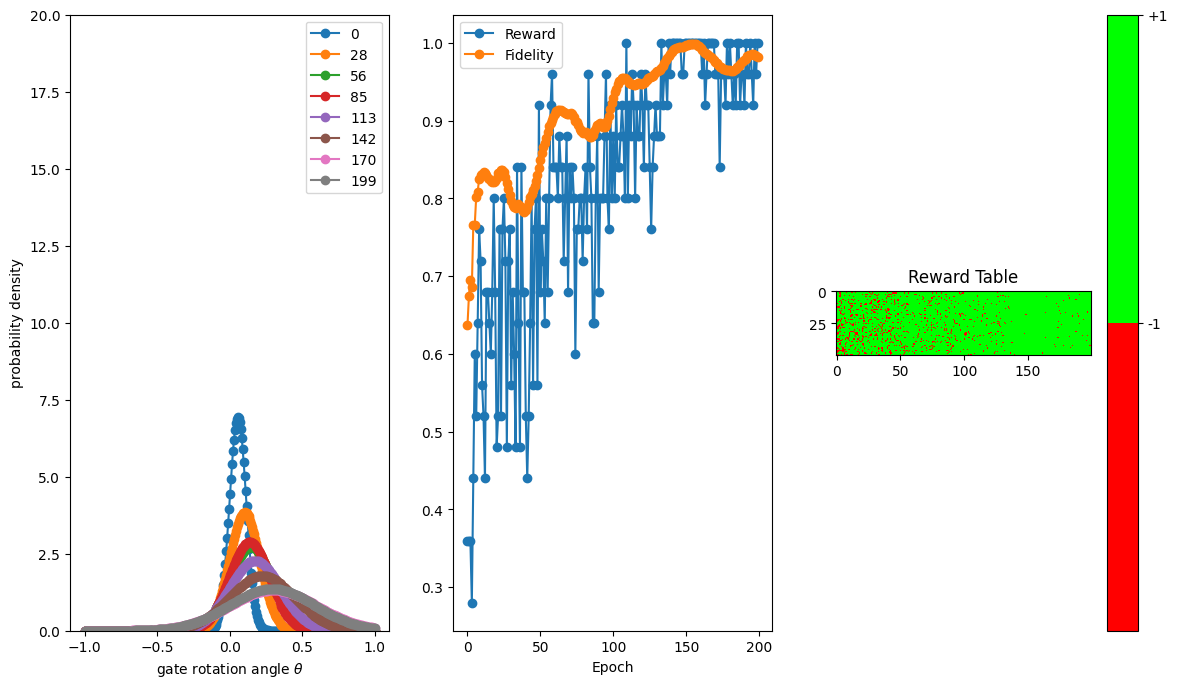

In [562]:
x = np.linspace(-1., 1., 300)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 8))
# Plot probability density associated to updated parameters for a few steps
for i in np.linspace(0, n_epochs-1, n_epochs//25, dtype=int):
    ax1.plot(x, norm.pdf(x, loc=params["mu"][i], scale=np.abs(params["mu"][i])), '-o', label=f'{i}')

ax1.set_xlabel(r"gate rotation angle $\theta$")
ax1.set_ylabel("probability density")
ax1.set_ylim(0., 20)
#  Plot return as a function of epochs
ax2.plot(np.mean(params["reward"], axis=1), '-o', label='Reward')
ax2.plot(params["fidelity"], '-o', label='Fidelity')
ax2.set_xlabel("Epoch")
ax2.legend()
ax1.legend()

rewards = np.array(params['reward']).transpose()
# Create a custom colormap
colors = [(1, 0, 0), (0, 1, 0)]  # R -> G
cmap_name = 'custom_red_green'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=2)

# Dummy data and imshow for ax3
cax = ax3.imshow(rewards, cmap=cm)
ax3.set_title("Reward Table")

# Add colorbar to ax3
cbar = fig.colorbar(cax, ax=ax3, ticks=[0, 1])
cbar.ax.set_yticklabels(['-1', '+1'])

plt.show()